In [1]:
import logging
from ome_zarr_utils import (
    write_omezarr,
    write_omezarr_ngff,
    omezarr_package,
    setup_logging,
)
from pathlib import Path
from czitools.read_tools import read_tools

In [2]:
# ========== Configuration Parameters ==========
# Toggle to display the result in napari viewer (requires napari installation)
show_napari: bool = True

# Backend library selection: OME_ZARR (ome-zarr-py) or NGFF_ZARR (ngff-zarr)
# ome_package = omezarr_package.OME_ZARR
ome_package = omezarr_package.NGFF_ZARR

# Scene ID for non-HCS format (ignored if write_hcs=True)
scene_id: int = 0

# Use absolute path to external test data
filepath: str = r"F:\Github\omezarr_playground\data\CellDivision5D.czi"

# ========== Setup Logging ==========
czi_path = Path(filepath)
log_file_path = czi_path.parent / f"{czi_path.stem}_conversion.log"

# Configure logging explicitly
setup_logging(str(log_file_path))
logger = logging.getLogger(__name__)

In [3]:
# Read the CZI file as a 6D array with dimension order STCZYX(A)
# S=Scene, T=Time, C=Channel, Z=Z-stack, Y=Height, X=Width, A=Angle (optional)
array, mdata = read_tools.read_6darray(filepath, planes={"S": (scene_id, scene_id)}, use_xarray=True)

# Extract the specified scene (remove Scene dimension to get 5D array)
# write_omezarr requires 5D array (TCZYX), not 6D (STCZYX)
array = array.squeeze("S")  # Remove the Scene dimension
logger.info(f"Array Type: {type(array)}, Shape: {array.shape}, Dtype: {array.dtype}")

2025-11-25 21:58:50,551 - czitools - INFO - CZI dimensions found: ['T', 'C', 'Z']


2025-11-25 21:58:50,551 - czitools - INFO - CZI dimensions found: ['T', 'C', 'Z']


Reading subblock planes: 0 2Dplanes [00:00, ? 2Dplanes/s]

Reading 2D planes: 0 2Dplanes [00:00, ? 2Dplanes/s]

2025-11-25 21:58:51,202 - __main__ - INFO - Array Type: <class 'xarray.core.dataarray.DataArray'>, Shape: (10, 2, 15, 256, 256), Dtype: uint16


In [4]:
logger.info(f"Converting CZI to HCS-ZARR format using {ome_package.name}...")

if ome_package == omezarr_package.OME_ZARR:
    # Generate output path with .ome.zarr extension
    zarr_output_path: Path = Path(str(filepath)[:-4] + ".ome.zarr")

    # Write OME-ZARR using ome-zarr-py backend
    zarr_output_path = write_omezarr(
        array, zarr_path=str(zarr_output_path), metadata=mdata, overwrite=True
    )
    logger.info(f"✓ Written OME-ZARR using ome-zarr-py: {zarr_output_path}")

elif ome_package == omezarr_package.NGFF_ZARR:
    # Generate output path with _ngff.ome.zarr extension
    zarr_output_path: Path = Path(str(filepath)[:-4] + "_ngff.ome.zarr")

    # Write OME-ZARR using ngff-zarr backend with multi-resolution pyramid
    # scale_factors=[2, 4] creates 3 resolution levels (1x, 2x, 4x downsampled)
    _ = write_omezarr_ngff(array,
                           zarr_output_path,
                           mdata, scale_factors=[2, 4],
                           overwrite=True)
    
    logger.info(f"✓ Written OME-ZARR using ngff-zarr: {zarr_output_path}")
else:
    raise ValueError(f"Unsupported ome_package: {ome_package}")

logger.info(f"✓ Converted to OME-ZARR HCS format at: {zarr_output_path}")

2025-11-25 21:58:54,750 - __main__ - INFO - Converting CZI to HCS-ZARR format using NGFF_ZARR...
2025-11-25 21:58:54,751 - ome_zarr_utils - INFO - ================================================================================
2025-11-25 21:58:54,752 - ome_zarr_utils - INFO - Writing OME-ZARR NGFF format with multiscale
2025-11-25 21:58:54,752 - ome_zarr_utils - INFO - ================================================================================
2025-11-25 21:58:54,752 - ome_zarr_utils - INFO - Input array shape: (10, 2, 15, 256, 256)
2025-11-25 21:58:54,753 - ome_zarr_utils - INFO - Output path: F:\Github\omezarr_playground\data\CellDivision5D_ngff.ome.zarr
2025-11-25 21:58:54,753 - ome_zarr_utils - INFO - Scale factors: [2, 4]
2025-11-25 21:58:56,806 - ome_zarr_utils - INFO - ================================================================================
2025-11-25 21:58:56,807 - ome_zarr_utils - INFO - NGFF OME-ZARR writing completed successfully!
2025-11-25 21:58:56,807 - ome_

In [5]:
if show_napari:
    import napari

    viewer = napari.Viewer()
    viewer.open(zarr_output_path, plugin="napari-ome-zarr")

2025-11-25 21:59:18,380 - ome_zarr.reader - INFO - root_attr: version
2025-11-25 21:59:18,380 - ome_zarr.reader - INFO - root_attr: multiscales
2025-11-25 21:59:18,381 - ome_zarr.reader - INFO - datasets [{'path': 'scale0/CellDivision5D.ome.zarr', 'coordinateTransformations': [{'scale': [1.0, 1.0, 0.32, 0.091, 0.091], 'type': 'scale'}, {'translation': [0.0, 0.0, 0.0, 0.0, 0.0], 'type': 'translation'}]}, {'path': 'scale1/CellDivision5D.ome.zarr', 'coordinateTransformations': [{'scale': [1.0, 1.0, 0.64, 0.182, 0.182], 'type': 'scale'}, {'translation': [0.0, 0.0, 0.16, 0.0455, 0.0455], 'type': 'translation'}]}, {'path': 'scale2/CellDivision5D.ome.zarr', 'coordinateTransformations': [{'scale': [1.0, 1.0, 1.28, 0.364, 0.364], 'type': 'scale'}, {'translation': [0.0, 0.0, 0.48, 0.1365, 0.1365], 'type': 'translation'}]}]
2025-11-25 21:59:18,389 - ome_zarr.reader - INFO - resolution: scale0/CellDivision5D.ome.zarr
2025-11-25 21:59:18,390 - ome_zarr.reader - INFO -  - shape ('t', 'c', 'z', 'y', 

2025-11-25 21:59:33,691 - OpenGL.acceleratesupport - INFO - No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


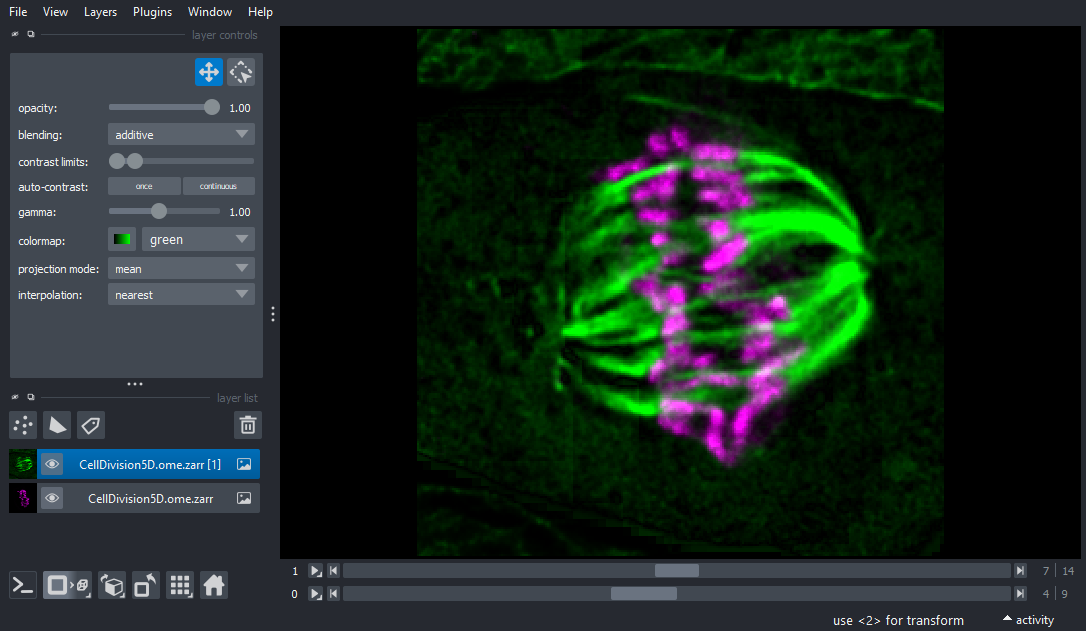

In [14]:
napari.utils.nbscreenshot(viewer)